<!-- 需要首先下载数据 -->

In [12]:
# 需要提前下载华为数据集（request部分）并放在当前目录下运行此代码

In [13]:
import os
import pandas as pd
from pathlib import Path
import gc
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import matplotlib as mpl

In [2]:
root_path = Path(".")  # 替换为实际路径
columns_to_keep = ["funcName", "cpu_usage", "memory_usage"]  # 替换为实际列名

# 确保temp文件夹存在
temp_folder = Path("./temp")
temp_folder.mkdir(exist_ok=True)

In [7]:

# 遍历根文件夹下的所有子文件夹
for subfolder in root_path.iterdir():
    # 跳过temp文件夹和非文件夹项
    if not subfolder.is_dir() or subfolder.name == "temp":
        continue
    
    print(f"正在处理文件夹: {subfolder.name}")
    
    # 遍历子文件夹中的所有CSV文件
    for csv_file in subfolder.glob("*.csv"):
        print(f"  处理文件: {csv_file.name}")
        
        try:
            # 使用分块读取来处理大文件
            chunksize = 100000  # 每次读取的行数，可根据内存调整
            temp_output_file = temp_folder / f"{csv_file.stem}_processed.csv"
            
            # 第一次读取以获取列信息并创建文件头
            first_chunk = True
            
            for chunk in pd.read_csv(csv_file, chunksize=chunksize, low_memory=False):
                # 只保留需要的列
                existing_columns = set(chunk.columns)
                columns_present = [col for col in columns_to_keep if col in existing_columns]
                
                if not columns_present:
                    print(f"  警告: {csv_file.name}中未找到指定的列，跳过此文件")
                    break
                
                # 选择需要的列
                filtered_chunk = chunk[columns_present]
                filtered_chunk = filtered_chunk[filtered_chunk['cpu_usage'] != float(0)]
                
                # 写入文件
                mode = 'w' if first_chunk else 'a'
                header = first_chunk
                
                filtered_chunk.to_csv(
                    temp_output_file, 
                    mode=mode, 
                    header=header, 
                    index=False
                )
                
                first_chunk = False
            
            if not first_chunk:  # 如果有数据写入
                print(f"  已保存到: {temp_output_file.name}")
            
            # 显式释放内存
            del chunk
            gc.collect()
            
        except Exception as e:
            print(f"  处理文件 {csv_file.name} 时出错: {str(e)}")
            continue

print("所有文件处理完成！")

正在处理文件夹: R3_00160_00199
  处理文件: part-00187-c1968859-adc2-4873-8b17-c5ef25f9b09f-c000.csv


KeyboardInterrupt: 

In [3]:
funcname_counter = Counter()
total_files = 0
processed_files = 0

csv_files = list(temp_folder.glob("*.csv"))
total_files = len(csv_files)

print(f"总共找到 {total_files} 个处理后的CSV文件。")

总共找到 200 个处理后的CSV文件。


In [11]:
for i, csv_file in enumerate(csv_files, 1):
        print(f"正在处理文件 [{i}/{total_files}]: {csv_file.name}")
        
        try:
            # 分块读取大文件
            chunksize = 100000  # 可根据内存调整
            first_chunk = True
            
            for chunk in pd.read_csv(csv_file, chunksize=chunksize, low_memory=False):
                # 检查是否有funcName列
                if 'funcName' not in chunk.columns:
                    print(f"  警告: {csv_file.name} 中没有funcName列，跳过此文件")
                    break
                
                # 过滤掉funcName为空或NaN的行
                chunk = chunk[chunk['funcName'].notna()]
                chunk = chunk[chunk['funcName'].astype(str).str.strip() != '']
                
                # 统计当前chunk中funcName的出现次数
                chunk_counts = chunk['funcName'].value_counts()
                
                # 更新总计数器
                for funcname, count in chunk_counts.items():
                    funcname_counter[funcname] += count
            
            processed_files += 1
            
            # 释放内存
            del chunk
            gc.collect()
            
            print(f"  已处理 {csv_file.name}，当前累计统计 {len(funcname_counter)} 个不同的funcName")
            
        except Exception as e:
            print(f"  处理文件 {csv_file.name} 时出错: {str(e)}")
            continue

正在处理文件 [1/200]: part-00059-c1968859-adc2-4873-8b17-c5ef25f9b09f-c000_processed.csv
  已处理 part-00059-c1968859-adc2-4873-8b17-c5ef25f9b09f-c000_processed.csv，当前累计统计 76 个不同的funcName
正在处理文件 [2/200]: part-00047-c1968859-adc2-4873-8b17-c5ef25f9b09f-c000_processed.csv
  已处理 part-00047-c1968859-adc2-4873-8b17-c5ef25f9b09f-c000_processed.csv，当前累计统计 98 个不同的funcName
正在处理文件 [3/200]: part-00100-c1968859-adc2-4873-8b17-c5ef25f9b09f-c000_processed.csv
  已处理 part-00100-c1968859-adc2-4873-8b17-c5ef25f9b09f-c000_processed.csv，当前累计统计 100 个不同的funcName
正在处理文件 [4/200]: part-00072-c1968859-adc2-4873-8b17-c5ef25f9b09f-c000_processed.csv
  已处理 part-00072-c1968859-adc2-4873-8b17-c5ef25f9b09f-c000_processed.csv，当前累计统计 105 个不同的funcName
正在处理文件 [5/200]: part-00135-c1968859-adc2-4873-8b17-c5ef25f9b09f-c000_processed.csv
  已处理 part-00135-c1968859-adc2-4873-8b17-c5ef25f9b09f-c000_processed.csv，当前累计统计 105 个不同的funcName
正在处理文件 [6/200]: part-00081-c1968859-adc2-4873-8b17-c5ef25f9b09f-c000_processed.csv
  已处理 part-00081-c1

In [ ]:
counts_df = pd.DataFrame(
    funcname_counter.items(), 
    columns=['funcName', 'count']
).sort_values('count', ascending=False)
counts_df.to_csv("funcname_counts.csv", index=False, encoding='utf-8-sig')

In [11]:
target_funcname='127'
all_cpu_usage = []
for csv_file in csv_files:
    for chunk in pd.read_csv(csv_file, chunksize=100000, low_memory=False):
        target_rows = chunk[chunk['funcName'].astype(str) == str(target_funcname)]
        if len(target_rows) > 0:
            cpu_data = pd.to_numeric(target_rows['cpu_usage'], errors='coerce')
            all_cpu_usage.extend(cpu_data.dropna().tolist())

/var/folders/8y/sc9p5k3d7cgd2v9p_pw1llxc0000gn/T/ipykernel_93936/3670047435.py:16: UserWarning: Glyph 27010 (\N{CJK UNIFIED IDEOGRAPH-6982}) missing from font(s) DejaVu Sans.
  plt.savefig(output_path, dpi=300, bbox_inches='tight')
/var/folders/8y/sc9p5k3d7cgd2v9p_pw1llxc0000gn/T/ipykernel_93936/3670047435.py:16: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from font(s) DejaVu Sans.
  plt.savefig(output_path, dpi=300, bbox_inches='tight')
/var/folders/8y/sc9p5k3d7cgd2v9p_pw1llxc0000gn/T/ipykernel_93936/3670047435.py:16: UserWarning: Glyph 23494 (\N{CJK UNIFIED IDEOGRAPH-5BC6}) missing from font(s) DejaVu Sans.
  plt.savefig(output_path, dpi=300, bbox_inches='tight')
/var/folders/8y/sc9p5k3d7cgd2v9p_pw1llxc0000gn/T/ipykernel_93936/3670047435.py:16: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) DejaVu Sans.
  plt.savefig(output_path, dpi=300, bbox_inches='tight')
/var/folders/8y/sc9p5k3d7cgd2v9p_pw1llxc0000gn/T/ipykernel_93936/3670047

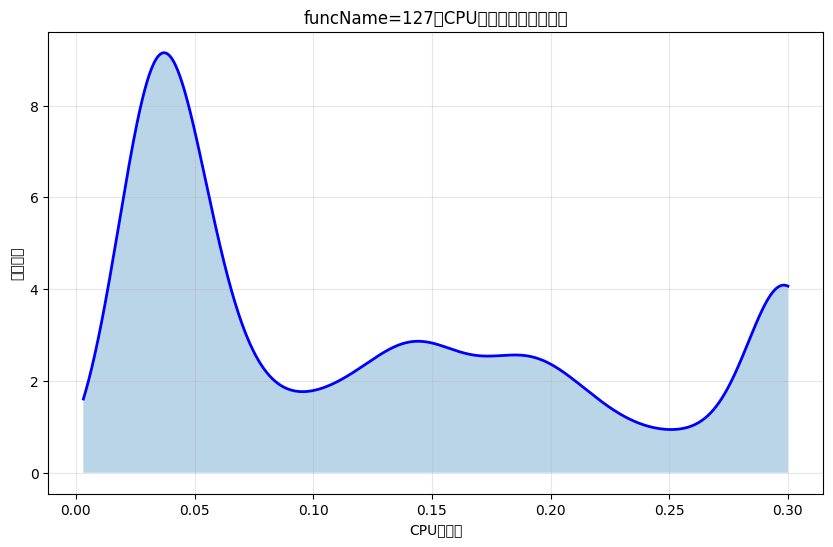

样本数: 10530
图片已保存: cpu_density_127.png


In [12]:
# 绘制概率密度图
cpu_array = np.array(all_cpu_usage)
density = stats.gaussian_kde(cpu_array)
x = np.linspace(cpu_array.min(), cpu_array.max(), 1000)

plt.figure(figsize=(10, 6))
plt.plot(x, density(x), 'b-', linewidth=2)
plt.fill_between(x, density(x), alpha=0.3)
plt.xlabel('CPU使用率')
plt.ylabel('概率密度')
plt.title(f'funcName={target_funcname}的CPU使用率概率密度分布')
plt.grid(True, alpha=0.3)

# 保存图片
output_path = f"cpu_density_{target_funcname}.png"
plt.savefig(output_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"样本数: {len(cpu_array)}")
print(f"图片已保存: {output_path}")


In [ ]:
counts_df = pd.read_csv("funcname_counts.csv")
funcnames = counts_df['funcName'].astype(str).tolist()

output_path = Path("./function")
output_path.mkdir(exist_ok=True)

['9', '206', '134', '127', '30', '26', '96', '22', '170', '61', '146', '31', '81', '40', '129', '176', '43', '156', '14', '85', '90', '47', '167', '101', '53', '172', '161', '49', '148', '80', '20', '143', '62', '88', '208', '164', '187', '199', '42', '91', '21', '209', '36', '38', '59', '1', '60', '23', '58', '109', '82', '123', '94', '86', '34', '83', '189', '175', '162', '7', '114', '29', '4', '64', '75', '50', '151', '44', '168', '39', '19', '215', '116', '131', '159', '137', '97', '108', '95', '160', '87', '128', '41', '117', '98', '113', '15', '193', '77', '124', '16', '35', '204', '149', '115', '179', '185', '76', '165', '178', '214', '139', '78', '33', '153', '201', '107', '3', '188', '154', '184', '152', '138', '155', '126', '133', '66', '136', '191', '63', '99', '10', '72', '118', '17', '12', '122', '195', '173', '125', '213', '198', '135', '71', '105', '171', '183', '150', '169', '45', '104', '73', '121', '102', '106', '216', '25', '69', '111', '140', '174', '202', '112', '9

In [19]:
for i, csv_file in enumerate(csv_files, 1):
    print(f"处理: {csv_file.name}")
    
    # 分块读取
    for chunk in pd.read_csv(csv_file, chunksize=100000, low_memory=False):
        if 'funcName' not in chunk.columns:
            continue
            
        # 按每个funcname筛选并保存
        for funcname in funcnames:
            mask = chunk['funcName'].astype(str) == funcname
            func_data = chunk[mask]
            
            if len(func_data) > 0:
                output_file = output_path / f"{funcname}.csv"
                
                # 追加模式写入
                if output_file.exists():
                    func_data.to_csv(output_file, mode='a', header=False, index=False)
                else:
                    func_data.to_csv(output_file, mode='w', index=False)

处理: part-00059-c1968859-adc2-4873-8b17-c5ef25f9b09f-c000_processed.csv
处理: part-00047-c1968859-adc2-4873-8b17-c5ef25f9b09f-c000_processed.csv
处理: part-00100-c1968859-adc2-4873-8b17-c5ef25f9b09f-c000_processed.csv
处理: part-00072-c1968859-adc2-4873-8b17-c5ef25f9b09f-c000_processed.csv
处理: part-00135-c1968859-adc2-4873-8b17-c5ef25f9b09f-c000_processed.csv
处理: part-00081-c1968859-adc2-4873-8b17-c5ef25f9b09f-c000_processed.csv
处理: part-00174-c1968859-adc2-4873-8b17-c5ef25f9b09f-c000_processed.csv
处理: part-00199-c1968859-adc2-4873-8b17-c5ef25f9b09f-c000_processed.csv
处理: part-00187-c1968859-adc2-4873-8b17-c5ef25f9b09f-c000_processed.csv
处理: part-00033-c1968859-adc2-4873-8b17-c5ef25f9b09f-c000_processed.csv
处理: part-00141-c1968859-adc2-4873-8b17-c5ef25f9b09f-c000_processed.csv
处理: part-00018-c1968859-adc2-4873-8b17-c5ef25f9b09f-c000_processed.csv
处理: part-00006-c1968859-adc2-4873-8b17-c5ef25f9b09f-c000_processed.csv
处理: part-00129-c1968859-adc2-4873-8b17-c5ef25f9b09f-c000_processed.csv
处理: pa

In [21]:
df = pd.read_csv("./funcname_counts.csv")
df['average_cpu'], df['average_memory'] = 0.0, 0.0

In [23]:
for f in Path("function").glob("*.csv"):
    total_cpu = total_mem = total_rows = 0
    for chunk in pd.read_csv(f, chunksize=100000):
        total_cpu += chunk['cpu_usage'].sum()
        total_mem += chunk['memory_usage'].sum()
        total_rows += len(chunk)
    mask = df['funcName'].astype(str) == f.stem
    if mask.any() and total_rows > 0:
        idx = df[mask].index[0]
        df.at[idx, 'average_cpu'] = total_cpu / total_rows
        df.at[idx, 'average_memory'] = total_mem / total_rows

In [35]:
df['ratio'] = df['average_cpu'] / df['average_memory'] * 1000
df.to_csv("funcname_counts.csv", index=False)

平均值: 3.315026152115261
标准差: 2.0694439164896803
变异系数: 62.42617166592197%


/Users/jiayunshan/Library/Python/3.10/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 32047 (\N{CJK UNIFIED IDEOGRAPH-7D2F}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/jiayunshan/Library/Python/3.10/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 31215 (\N{CJK UNIFIED IDEOGRAPH-79EF}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/jiayunshan/Library/Python/3.10/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 27010 (\N{CJK UNIFIED IDEOGRAPH-6982}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/jiayunshan/Library/Python/3.10/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/jiayunshan/Library/Python/3.10/lib/python/site-packages/IPython/core/pylabtoo

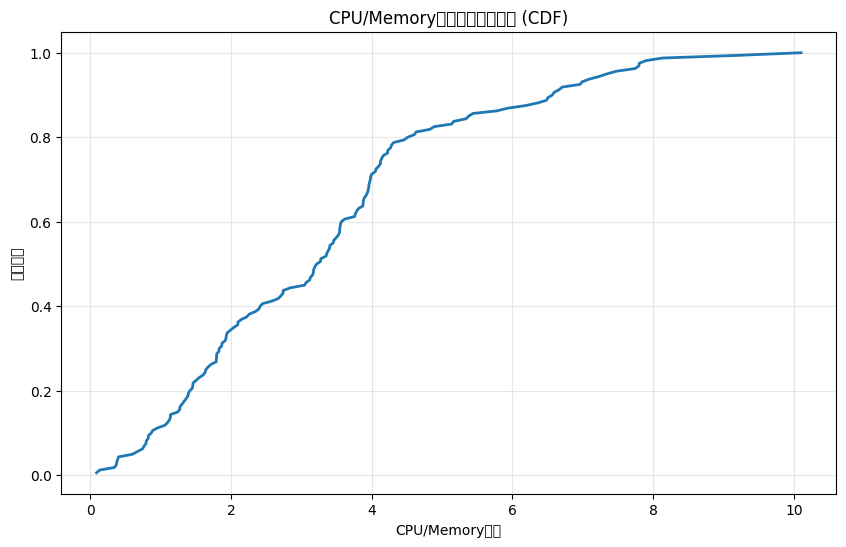

In [41]:
ratio = df['average_cpu'] / df['average_memory'] * 1000

# 计算CDF
sorted_data = np.sort(ratio)
cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)

std = ratio.std()
mean = ratio.mean()
print(f"平均值: {mean}")
print(f"标准差: {std}")
cv = std / mean * 100  # 变异系数
print(f"变异系数: {cv}%")

# 绘制CDF图
plt.figure(figsize=(10, 6))
plt.plot(sorted_data, cdf, linewidth=2)
plt.xlabel('CPU/Memory比值')
plt.ylabel('累积概率')
plt.title('CPU/Memory比值累积分布函数 (CDF)')
plt.grid(True, alpha=0.3)
plt.show()

Dataset size: 160 functions
Ratio statistics:
  Mean: 3.315
  Std: 2.069
  Min: 0.087
  Max: 10.102
  Median: 3.244


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Figure saved as: cdf_cpu_memory_ratio.png
Figure saved as: cdf_cpu_memory_ratio.pdf
Figure saved as: cdf_cpu_memory_ratio.eps


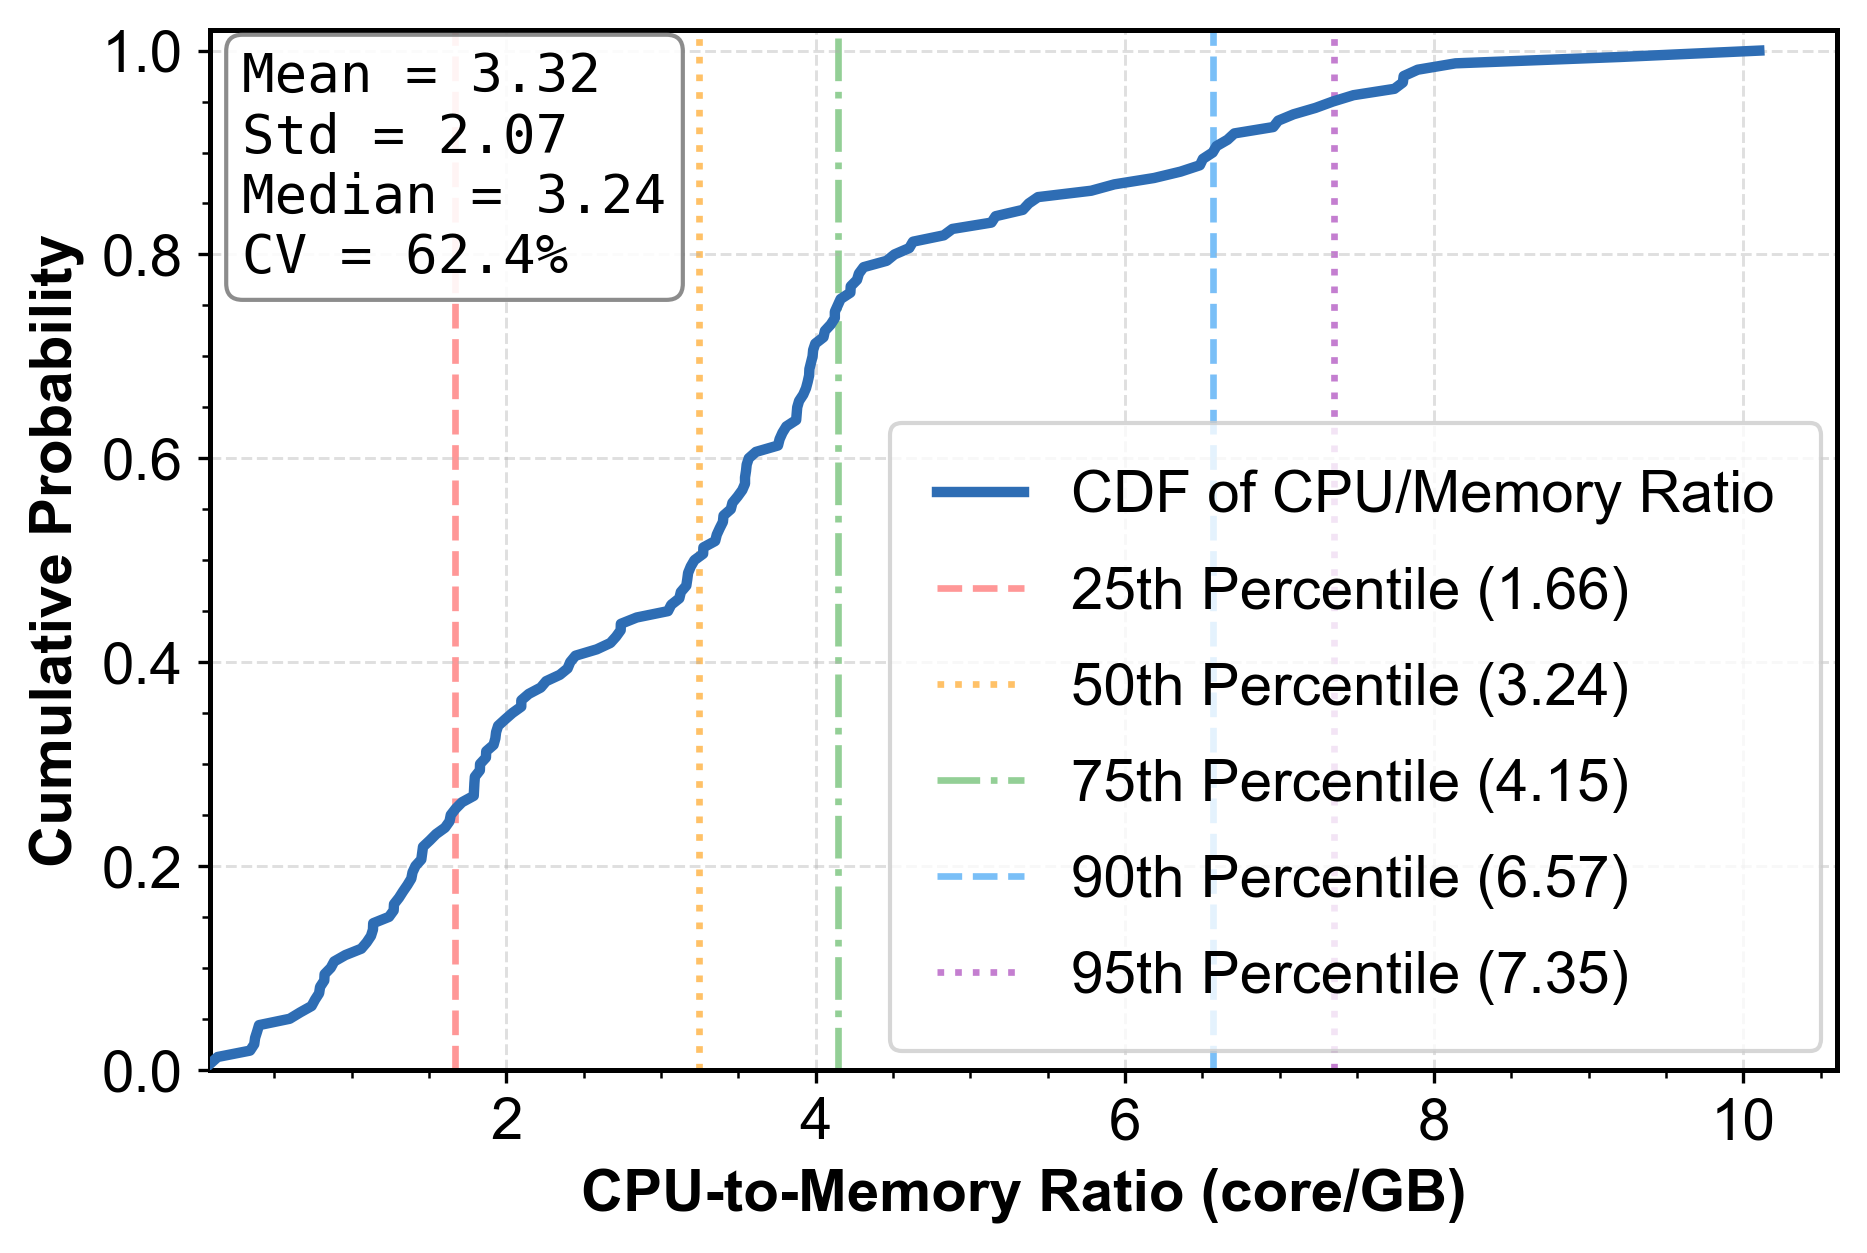


STATISTICAL SUMMARY OF CPU-TO-MEMORY RATIOS
Percentile   Value      Interpretation                
------------------------------------------------------------
10%:       0.885      10% of functions have ratio ≤ 0.88
25%:       1.665      Lower quartile (25% ≤ 1.66)   
50%:       3.244      Median (50% ≤ 3.24)           
75%:       4.148      Upper quartile (75% ≤ 4.15)   
90%:       6.570      90% of functions have ratio ≤ 6.57
95%:       7.351      95% of functions have ratio ≤ 7.35
99%:       8.575      99% of functions have ratio ≤ 8.58

Interquartile Range (IQR): 2.483
Coefficient of Variation: 62.4%


In [11]:
# ===============================
# 1. SETUP PUBLICATION-QUALITY FIGURE
# ===============================
plt.rcParams.update({
    'font.size': 24,
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial', 'DejaVu Sans'],
    'axes.labelsize': 24,
    'axes.titlesize': 14,
    'axes.labelweight': 'bold',
    'axes.linewidth': 1.2,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 14,
    'figure.dpi': 300,
    'savefig.dpi': 600,
    'savefig.bbox': 'tight',
    'savefig.pad_inches': 0.1,
    'lines.linewidth': 2.5,
    'grid.alpha': 0.3,
    'grid.linewidth': 0.5
})

# ===============================
# 2. LOAD DATA AND CALCULATE RATIO
# ===============================
# Load function statistics
df = pd.read_csv('funcname_counts.csv')

# Calculate CPU-to-Memory ratio
df['ratio'] = df['average_cpu'] / df['average_memory'] * 1000  # Scale ratio for better interpretability

# Remove invalid values (NaN, infinite)
valid_ratio = df['ratio'].replace([np.inf, -np.inf], np.nan).dropna()

print(f"Dataset size: {len(valid_ratio)} functions")
print(f"Ratio statistics:")
print(f"  Mean: {valid_ratio.mean():.3f}")
print(f"  Std: {valid_ratio.std():.3f}")
print(f"  Min: {valid_ratio.min():.3f}")
print(f"  Max: {valid_ratio.max():.3f}")
print(f"  Median: {valid_ratio.median():.3f}")

# ===============================
# 3. CALCULATE CDF
# ===============================
# Sort data for CDF calculation
sorted_ratio = np.sort(valid_ratio.values)
cdf_values = np.arange(1, len(sorted_ratio) + 1) / len(sorted_ratio)

# Calculate key percentiles
percentiles = [10, 25, 50, 75, 90, 95, 99]
percentile_values = {p: np.percentile(sorted_ratio, p) for p in percentiles}

# ===============================
# 4. CREATE FIGURE
# ===============================
fig, ax = plt.subplots(1, 1, figsize=(7, 4.5))

# Plot CDF curve
ax.plot(sorted_ratio, cdf_values, 
        color='#2E6DB4',  # Professional blue
        linewidth=2.5,
        label='CDF of CPU/Memory Ratio',
        zorder=5)

# Add horizontal grid for better readability
ax.grid(True, which='major', axis='both', linestyle='--', alpha=0.4, linewidth=0.7)

# Add vertical lines for key percentiles
percentile_colors = ['#FF6B6B', '#FFA726', '#66BB6A', '#42A5F5', '#AB47BC']
percentile_styles = ['--', ':', '-.', '--', ':']

for i, p in enumerate([25, 50, 75, 90, 95]):
    p_value = percentile_values[p]
    ax.axvline(x=p_value, 
               color=percentile_colors[i % len(percentile_colors)],
               linestyle=percentile_styles[i % len(percentile_styles)],
               alpha=0.7,
               linewidth=1.6,
               label=f'{p}th Percentile ({p_value:.2f})',
               zorder=1)

# ===============================
# 5. FORMATTING
# ===============================
# Set labels with proper units if known
ax.set_xlabel('CPU-to-Memory Ratio (core/GB)', fontweight='bold', fontsize=14)
ax.set_ylabel('Cumulative Probability', fontweight='bold', fontsize=14)

# Set appropriate limits
ax.set_xlim(left=max(0, sorted_ratio[0] * 0.95),  # Start slightly below min
            right=sorted_ratio[-1] * 1.05)         # Extend slightly beyond max
ax.set_ylim(0, 1.02)

# Add minor ticks for better precision
ax.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(4))
ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(4))

# Add descriptive title
# ax.set_title('Cumulative Distribution of CPU-to-Memory Ratio Across Functions', 
#              fontweight='bold', fontsize=14, pad=15)

# ===============================
# 6. ADD STATISTICS ANNOTATION
# ===============================
stats_text = (
    f'Mean = {valid_ratio.mean():.2f}\n'
    f'Std = {valid_ratio.std():.2f}\n'
    f'Median = {valid_ratio.median():.2f}\n'
    f'CV = {valid_ratio.std()/valid_ratio.mean()*100:.1f}%'
)

# Place text box in upper left
props = dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='gray')
ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, fontsize=13,
        verticalalignment='top', bbox=props, fontfamily='monospace')

# ===============================
# 7. LEGEND AND FINAL TOUCHES
# ===============================
# Place legend outside plot to avoid overlap
ax.legend(loc='center left', bbox_to_anchor=(0.4, 0.32),
          frameon=True, fancybox=True, shadow=False,
          borderpad=0.8, labelspacing=0.7, handlelength=1.5)

# # Adjust layout to accommodate external legend
# plt.tight_layout(rect=[0, 0, 0.85, 1])

# ===============================
# 8. SAVE FIGURE
# ===============================
output_formats = ['png', 'pdf', 'eps']  # PDF/EPS for publication, PNG for review
for fmt in output_formats:
    output_file = f'cdf_cpu_memory_ratio.{fmt}'
    plt.savefig(output_file, dpi=600 if fmt == 'png' else None)
    print(f"Figure saved as: {output_file}")

# ===============================
# 9. DISPLAY
# ===============================
plt.show()

# ===============================
# 10. ADDITIONAL STATISTICAL SUMMARY
# ===============================
print("\n" + "="*60)
print("STATISTICAL SUMMARY OF CPU-TO-MEMORY RATIOS")
print("="*60)
print(f"{'Percentile':<12} {'Value':<10} {'Interpretation':<30}")
print("-"*60)

interpretations = {
    10: "10% of functions have ratio ≤ {:.2f}",
    25: "Lower quartile (25% ≤ {:.2f})",
    50: "Median (50% ≤ {:.2f})",
    75: "Upper quartile (75% ≤ {:.2f})",
    90: "90% of functions have ratio ≤ {:.2f}",
    95: "95% of functions have ratio ≤ {:.2f}",
    99: "99% of functions have ratio ≤ {:.2f}"
}

for p in percentiles:
    value = percentile_values[p]
    if p in interpretations:
        interp = interpretations[p].format(value)
    else:
        interp = f"{p}% of functions have ratio ≤ {value:.2f}"
    print(f"{p}%: {'':<5} {value:<10.3f} {interp:<30}")

# Calculate interquartile range (IQR)
iqr = percentile_values[75] - percentile_values[25]
print(f"\nInterquartile Range (IQR): {iqr:.3f}")
print(f"Coefficient of Variation: {valid_ratio.std()/valid_ratio.mean()*100:.1f}%")

In [61]:
df = pd.read_csv('funcname_counts.csv')
df['cpu_cv'] = 0.0

for f in Path('function').glob('*.csv'):
    total = total_sq = count = 0
    for chunk in pd.read_csv(f, chunksize=100000):
        cpu = pd.to_numeric(chunk['cpu_usage'], errors='coerce').dropna()
        total += cpu.sum()
        total_sq += (cpu**2).sum()
        count += len(cpu)
    
    mask = df['funcName'].astype(str) == f.stem
    if mask.any() and count > 0:
        mean = total/count
        std = (total_sq/count - mean**2)**0.5
        df.loc[mask, 'cpu_cv'] = std/mean*100 if mean!=0 else 0
        
df.to_csv('funcname_counts.csv', index=False)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Figure saved as: cdf_cpu_cv_regions.png
Figure saved as: cdf_cpu_cv_regions.pdf
Figure saved as: cdf_cpu_cv_regions.eps


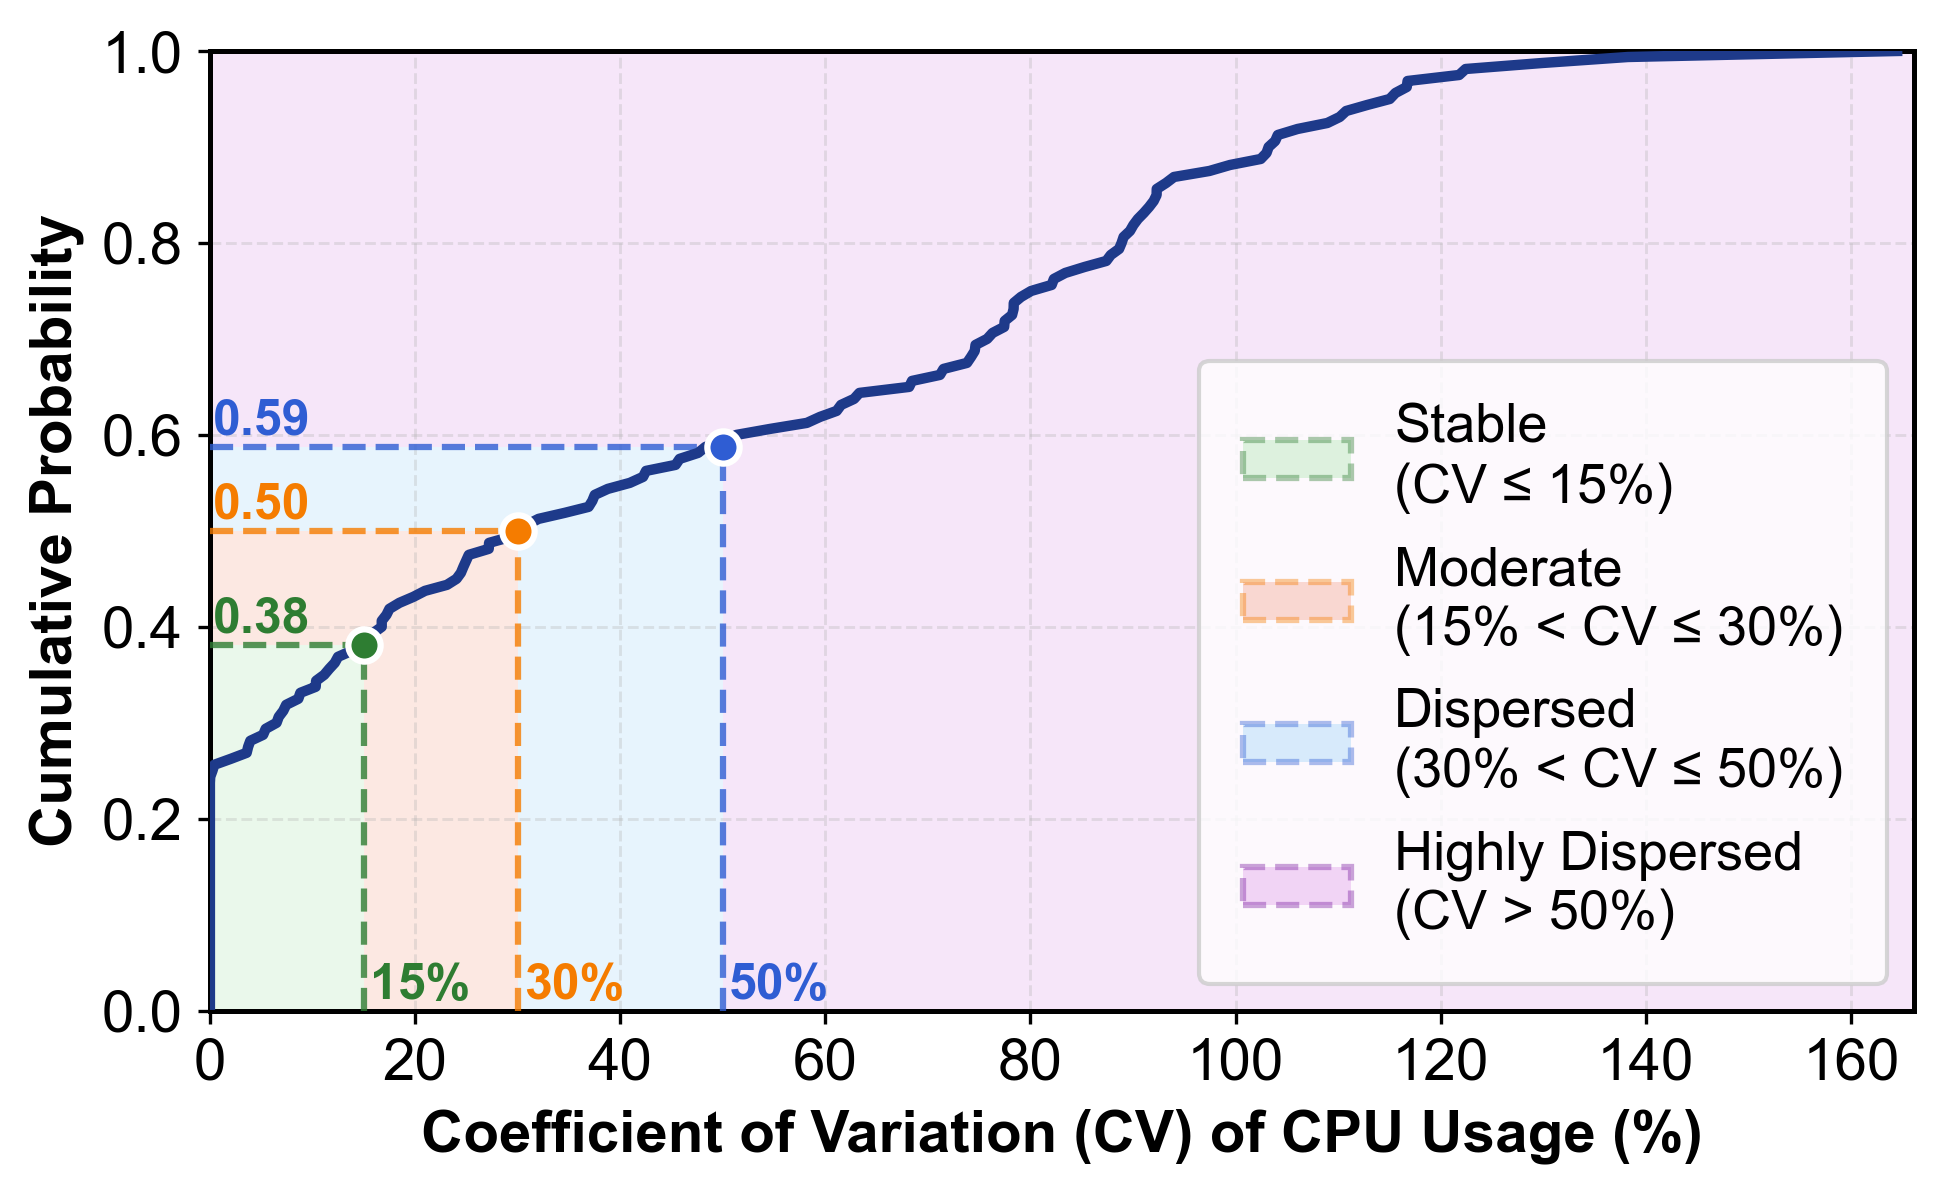


CPU USAGE STABILITY STATISTICS
Total functions analyzed: 160
Median CV: 30.2%
Mean CV: 44.0%

Distribution by stability category:
  Stable
(CV ≤ 15%): 61 functions (38.1%)
  Moderate
(15% < CV ≤ 30%): 19 functions (11.9%)
  Dispersed
(30% < CV ≤ 50%): 14 functions (8.8%)
  Highly Dispersed
(CV > 50%): 66 functions (41.2%)


In [9]:
# ===============================
# 1. PUBLICATION QUALITY SETTINGS
# ===============================
plt.rcParams.update({
    'font.size': 24,
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial', 'DejaVu Sans'],
    'axes.labelsize': 24,
    'axes.titlesize': 14,
    'axes.labelweight': 'bold',
    'axes.linewidth': 1.2,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 13,
    'figure.dpi': 300,
    'savefig.dpi': 600,
    'savefig.bbox': 'tight',
    'savefig.pad_inches': 0.1,
    'lines.linewidth': 2.5,
    'grid.alpha': 0.3,
    'grid.linewidth': 0.5
})

# ===============================
# 2. DATA PREPARATION
# ===============================
# Load data
df = pd.read_csv('funcname_counts.csv')

# Get CPU CV values and sort
cv_values = df['cpu_cv'].dropna().values
cv_sorted = np.sort(cv_values)
cdf = np.arange(1, len(cv_sorted) + 1) / len(cv_sorted)

# Find indices for CV thresholds
thresholds = [15, 30, 50, 200]  # CV thresholds in percent
threshold_indices = [np.searchsorted(cv_sorted, t, side='right') - 1 for t in thresholds]
threshold_cdf = [cdf[idx] if idx >= 0 else 0 for idx in threshold_indices]

# ===============================
# 3. CREATE FIGURE
# ===============================
fig, ax = plt.subplots(figsize=(7, 4.5))

# Define region colors (pastel colors for background)
region_colors = ["#AEE6B0", "#F4A68F", "#A0D4F9", "#DF9DEA"]  # Green, Orange, Red, Purple
region_labels = ['Stable\n(CV ≤ 15%)', 
                 'Moderate\n(15% < CV ≤ 30%)', 
                 'Dispersed\n(30% < CV ≤ 50%)', 
                 'Highly Dispersed\n(CV > 50%)']

# ===============================
# 4. BACKGROUND REGIONS
# ===============================
# Fill background regions
x_min, x_max = 0, cv_sorted[-1]* 1.01

for i in range(len(thresholds)):
    if i == 0:
        x_start = 0
    else:
        x_start = thresholds[i-1]
    
    x_end = thresholds[i] if i < len(thresholds) - 1 else x_max
    y_start, y_end = 0, threshold_cdf[i]
    
    ax.fill_between([x_start, x_end], y1=y_start, y2=y_end,
               alpha=0.25, 
               color=region_colors[i % len(region_colors)],
               edgecolor='none')
    y_start = 0 if i == 0 else threshold_cdf[i-1]
    ax.fill_between([0, x_start], y1=y_start, y2=y_end,
               alpha=0.25, 
               color=region_colors[i % len(region_colors)],
               edgecolor='none')

# ===============================
# 5. PLOT CDF
# ===============================
# Plot CDF curve
ax.plot(cv_sorted, cdf, 
        color='#1E3A8A',  # Deep blue
        linewidth=2.5,
        zorder=5)

# ===============================
# 6. THRESHOLD LINES AND ANNOTATIONS
# ===============================
# Colors for threshold lines
line_colors = ['#2E7D32', '#F57C00', "#2F5DD3", '#7B1FA2']  # Green, Orange, Red, Purple

for i, (threshold, cdf_val, color) in enumerate(zip(thresholds[:3], threshold_cdf[:3], line_colors[:3])):
    # Vertical line at threshold
    ax.axvline(x=threshold, ymin=0, ymax=cdf_val,
               color=color,
               linestyle='--',
               linewidth=1.5,
               alpha=0.8,
               zorder=4)
    
    # Horizontal line from CDF curve
    if cdf_val > 0:
        ax.plot([0, threshold], [cdf_val, cdf_val], 
                color=color,
                linestyle='--',
                linewidth=1.5,
                alpha=0.8,
                zorder=4)
        
        # Add point marker at intersection
        ax.scatter(threshold, cdf_val, 
                   color=color,
                   s=60,
                   edgecolor='white',
                   linewidth=1.5,
                   zorder=6,
                   marker='o')
    
    # Add threshold value labels
    ax.text(threshold + 5.5, 0.05, f'{threshold}%',
            transform=ax.get_xaxis_transform(),
            ha='center', va='top',
            fontsize=12, fontweight='bold',
            color=color)
    
    ax.text(5, cdf_val + 0.05, f'{cdf_val:.2f}',
            transform=ax.get_xaxis_transform(),
            ha='center', va='top',
            fontsize=12, fontweight='bold',
            color=color)

# ===============================
# 7. AXIS AND LABEL FORMATTING
# ===============================
ax.set_xlabel('Coefficient of Variation (CV) of CPU Usage (%)', 
              fontweight='bold', fontsize=14)
ax.set_ylabel('Cumulative Probability', 
              fontweight='bold', fontsize=14)

# Set limits
ax.set_xlim(0, x_max)
ax.set_ylim(0, 1)

# Add grid
ax.grid(True, which='major', linestyle='--', alpha=0.3, linewidth=0.7)

# Add title
# ax.set_title('Cumulative Distribution of CPU Usage Stability Across Functions',
#              fontweight='bold', fontsize=14, pad=15)

# ===============================
# 8. REGION LEGEND
# ===============================
# Create custom patches for legend
from matplotlib.patches import Patch
legend_patches = [Patch(facecolor=region_colors[i], 
                        alpha=0.4, 
                        edgecolor=line_colors[i],
                        linestyle='--',
                        linewidth=1.5,
                        label=region_labels[i]) 
                  for i in range(len(region_labels))]

ax.legend(handles=legend_patches,
          loc='lower right',
          frameon=True,
          fancybox=True,
          shadow=False,
          borderpad=0.8,
          labelspacing=0.6)

# ===============================
# 9. SAVE AND SHOW
# ===============================
plt.tight_layout()

# Save in multiple formats
for fmt in ['png', 'pdf', 'eps']:
    output_file = f'cdf_cpu_cv_regions.{fmt}'
    plt.savefig(output_file, dpi=600 if fmt == 'png' else None)
    print(f"Figure saved as: {output_file}")

plt.show()

# ===============================
# 10. PRINT STATISTICS
# ===============================
print("\n" + "="*60)
print("CPU USAGE STABILITY STATISTICS")
print("="*60)
print(f"Total functions analyzed: {len(cv_sorted):,}")
print(f"Median CV: {np.median(cv_sorted):.1f}%")
print(f"Mean CV: {cv_sorted.mean():.1f}%")

print("\nDistribution by stability category:")
for i, threshold in enumerate(thresholds):
    if i == 0:
        count = np.sum(cv_sorted <= threshold)
    elif i < len(thresholds) - 1:
        count = np.sum((cv_sorted > thresholds[i-1]) & (cv_sorted <= threshold))
    else:
        count = np.sum(cv_sorted > thresholds[i-1])
    
    percentage = count / len(cv_sorted) * 100
    print(f"  {region_labels[i]}: {count:,} functions ({percentage:.1f}%)")

In [133]:
def plot_cpu_density_simple(func_id, folder='function'):
    """最简版本"""
    file = Path(folder) / f"{func_id}.csv"
    
    # 收集数据
    data = []
    for chunk in pd.read_csv(file, chunksize=100000):
        if 'cpu_usage' in chunk.columns:
            cpu = pd.to_numeric(chunk['cpu_usage'], errors='coerce').dropna()
            data.extend(cpu.tolist())
    
    # 绘制
    plt.figure(figsize=(10, 6))
    plt.hist(data, bins=50, density=True, alpha=0.7, edgecolor='black')
    plt.xlabel('CPU Usage')
    plt.ylabel('Probability Density')
    plt.title(f'CPU Usage Distribution - Function {func_id}')
    plt.grid(True, alpha=0.3)
    
    # 保存
    plt.savefig(f'cpu_density_{func_id}.png', dpi=300, bbox_inches='tight')
    plt.show()

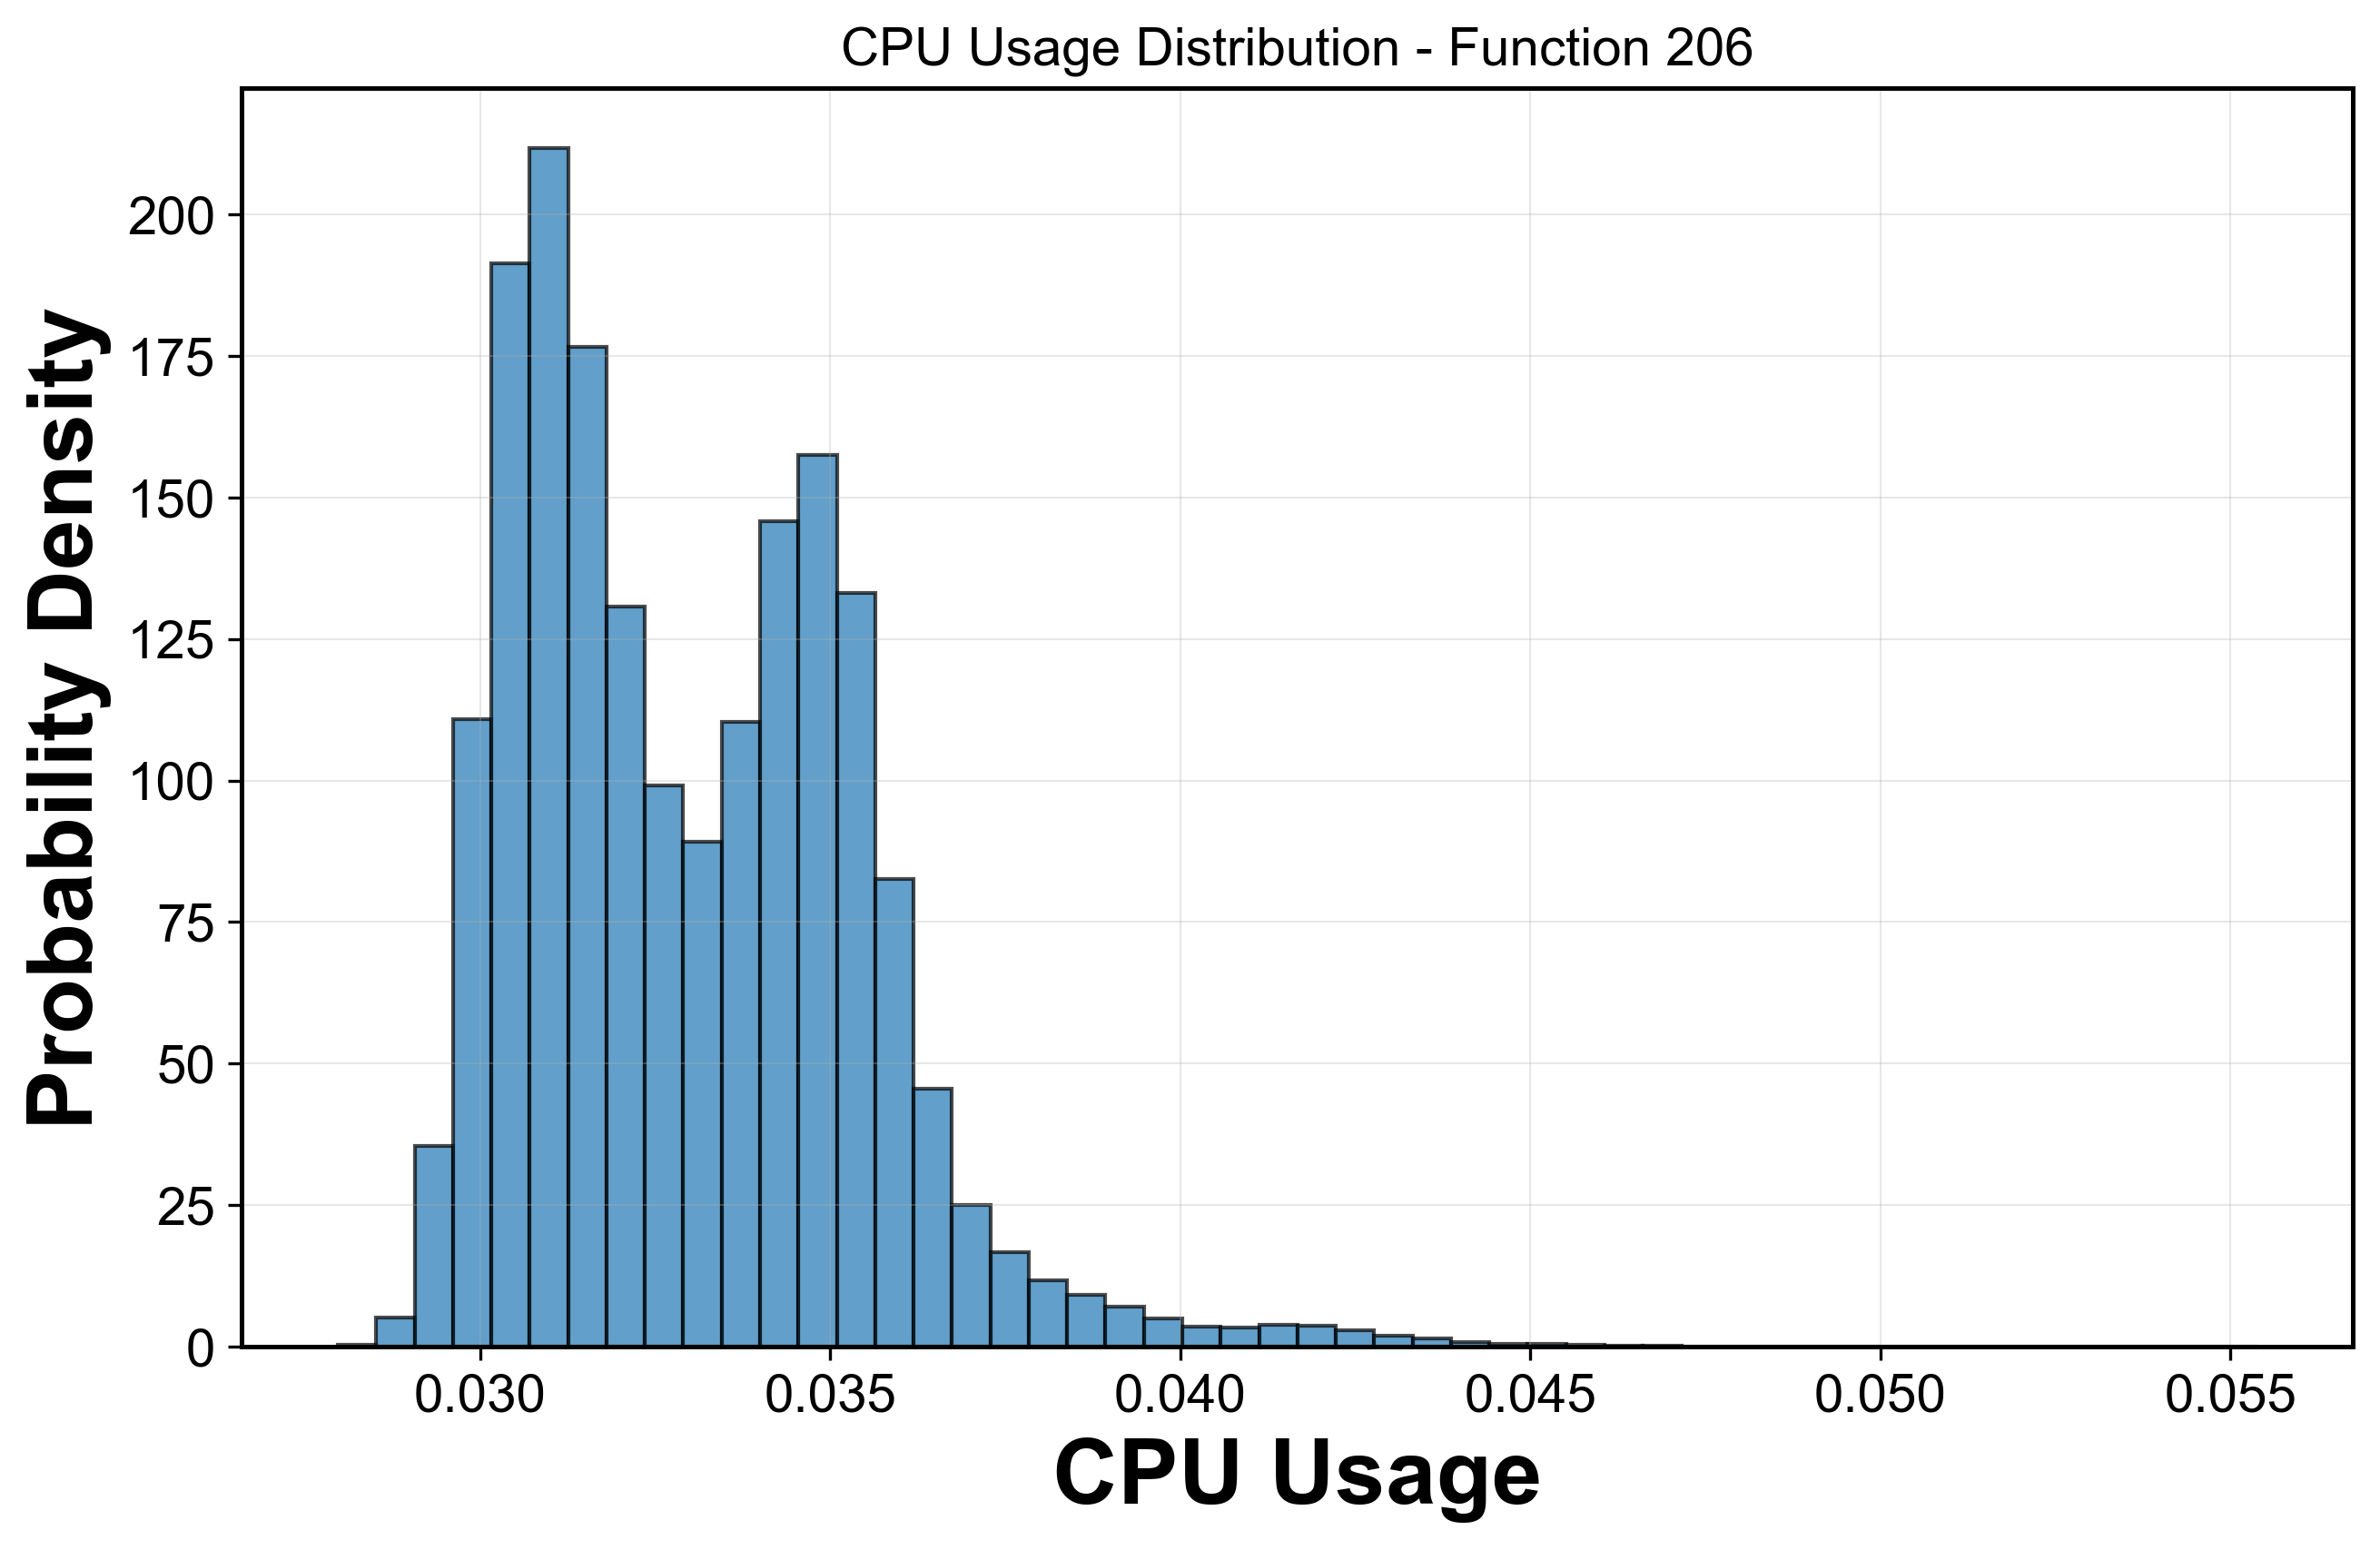

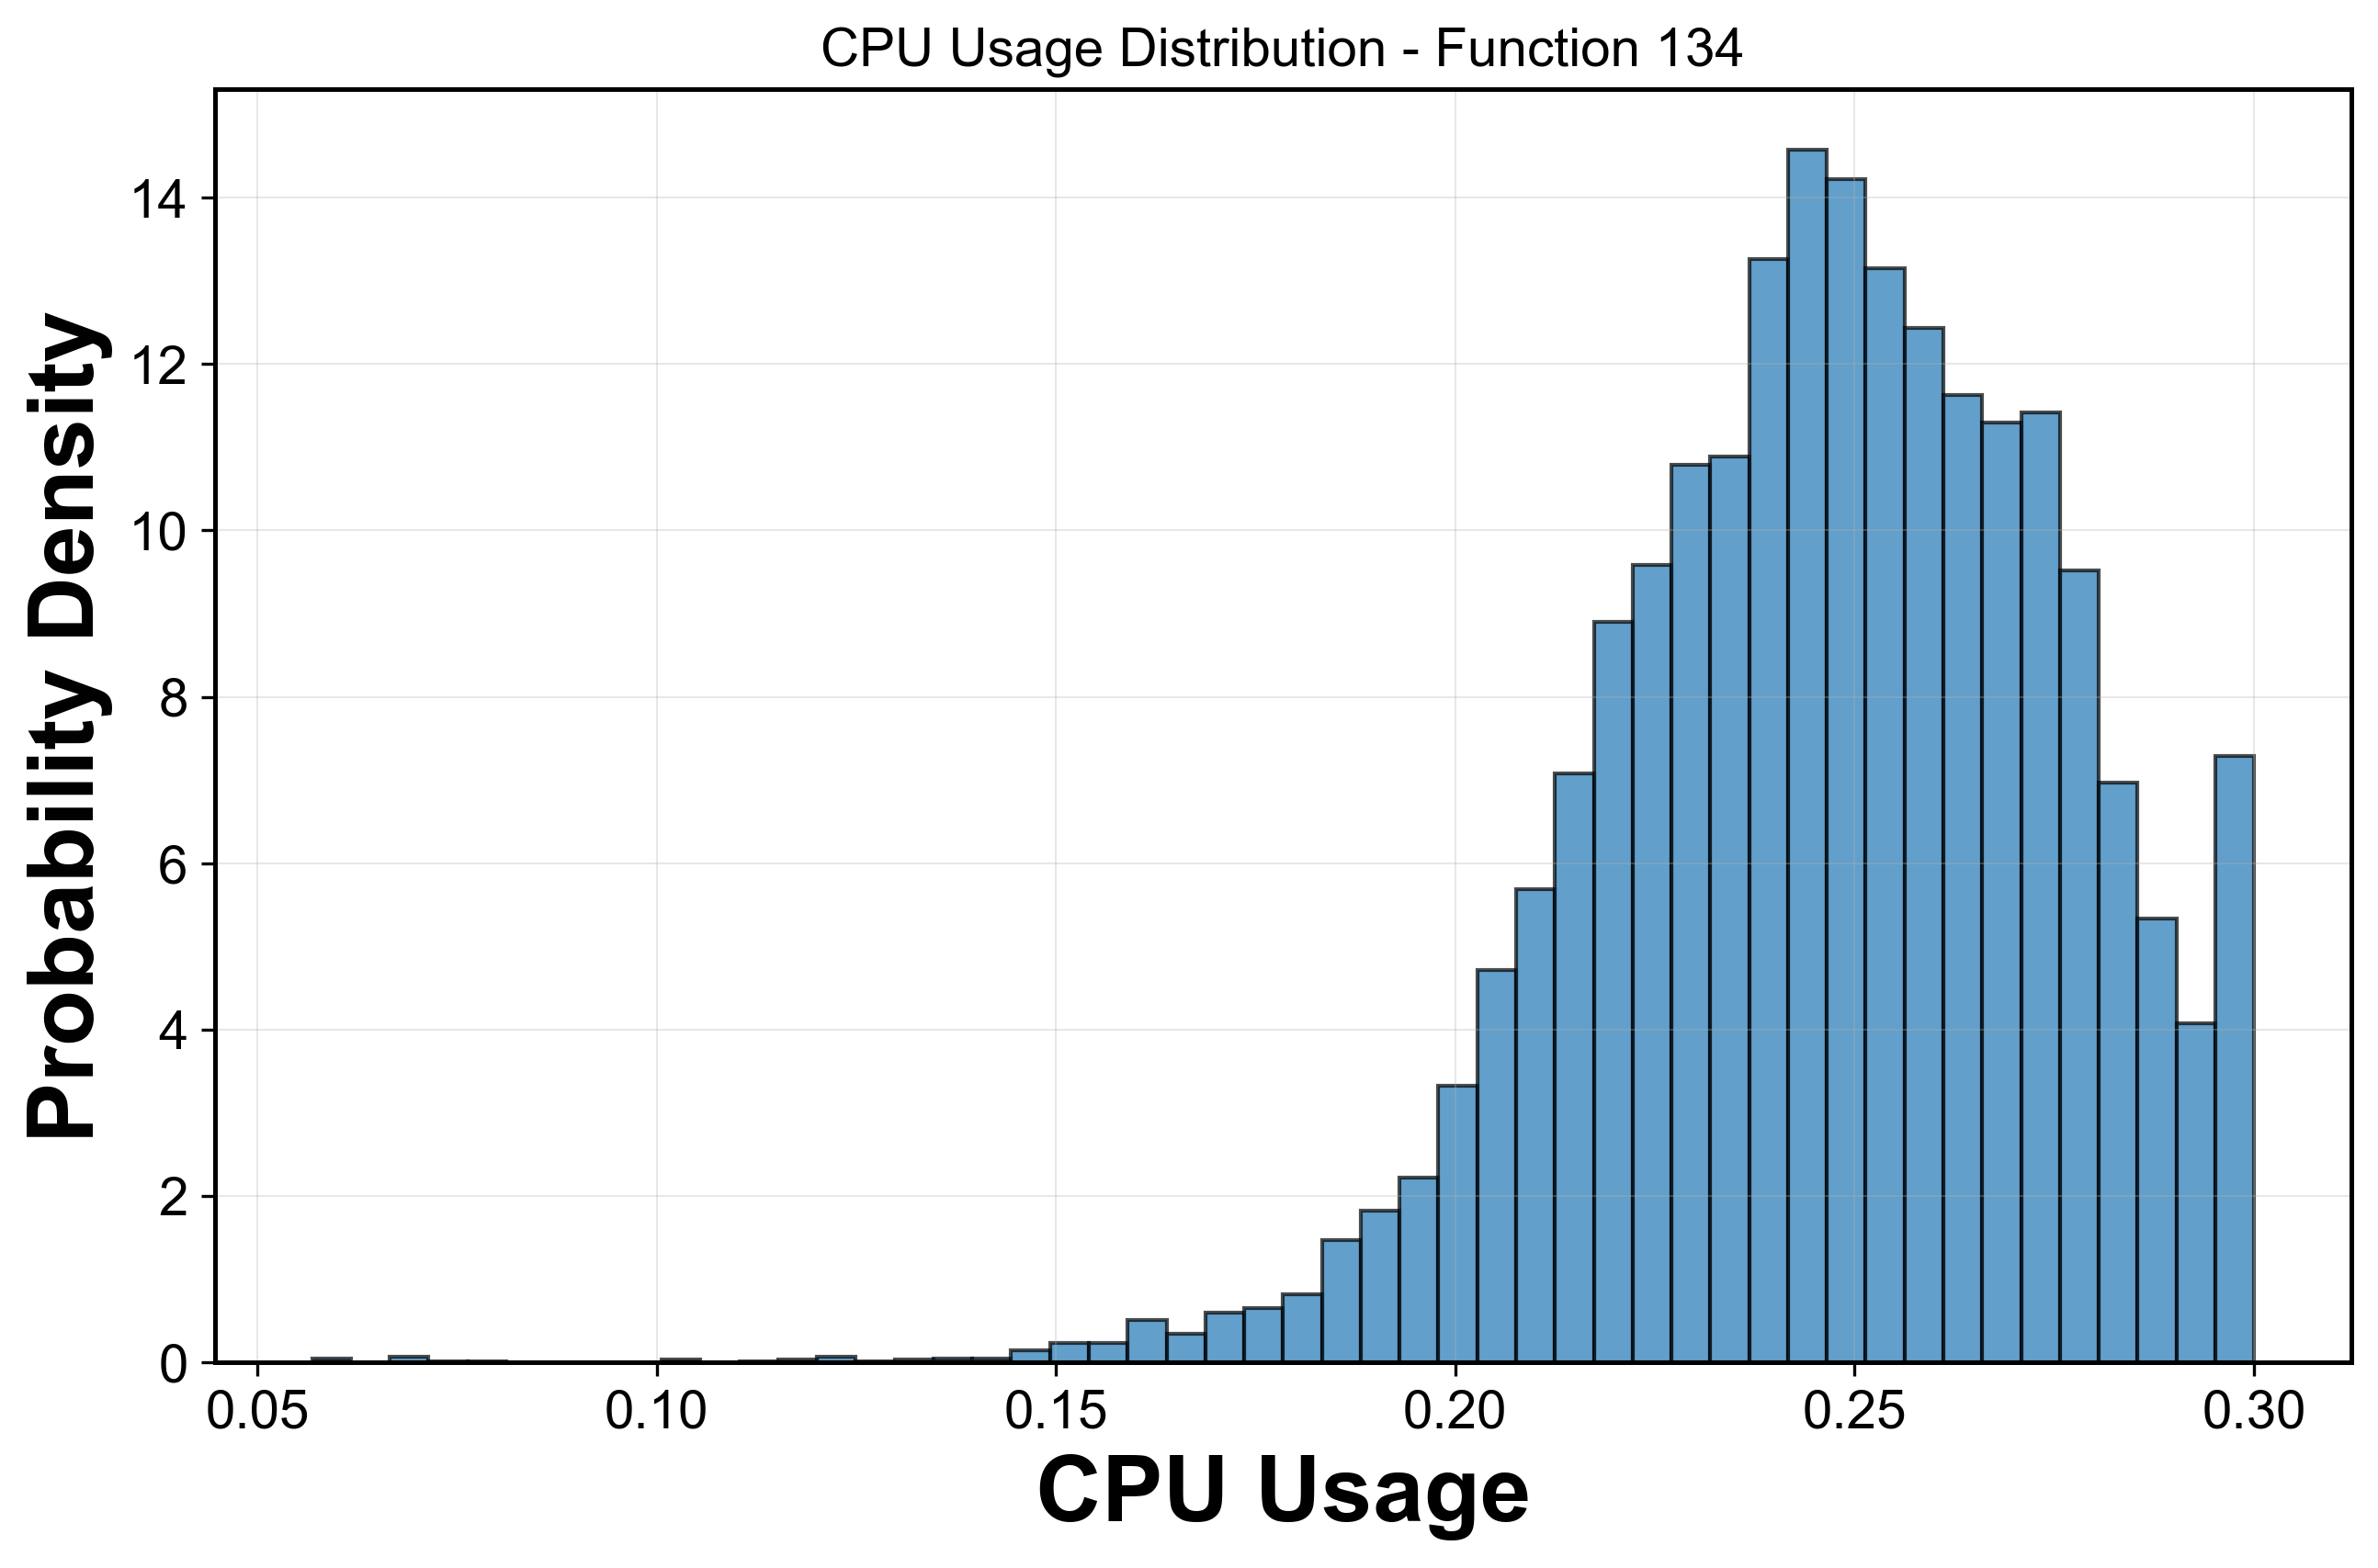

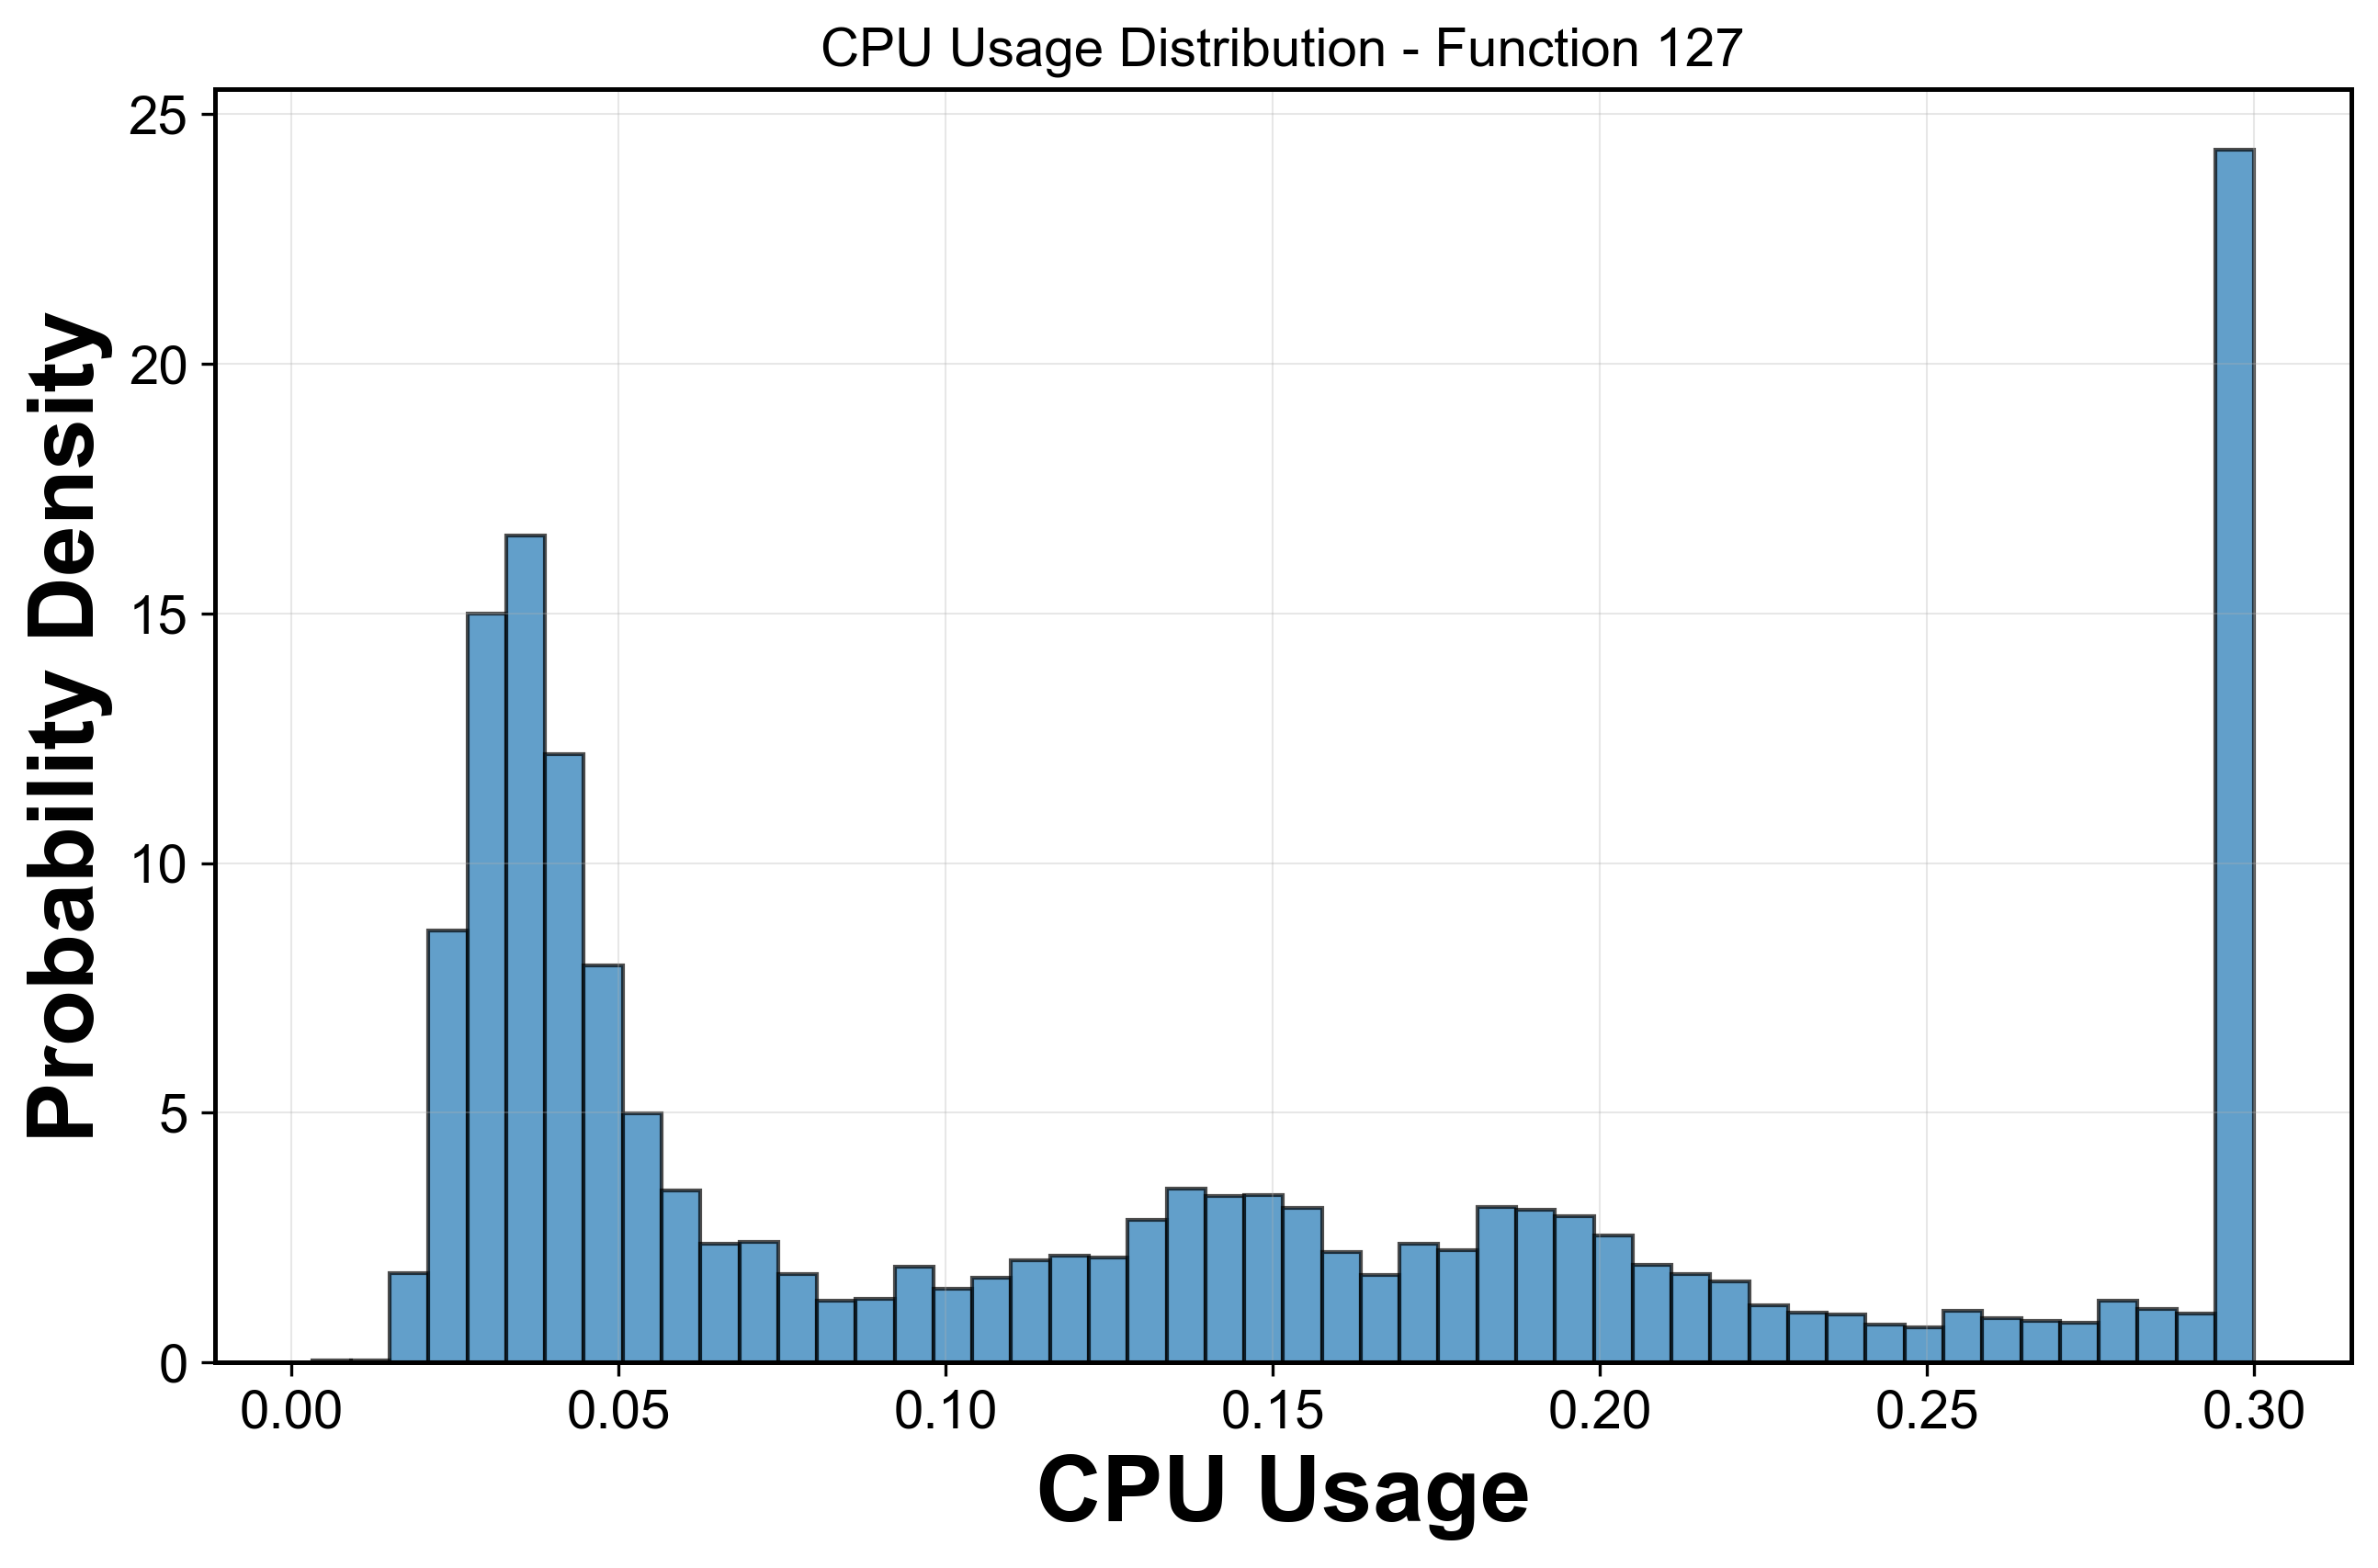

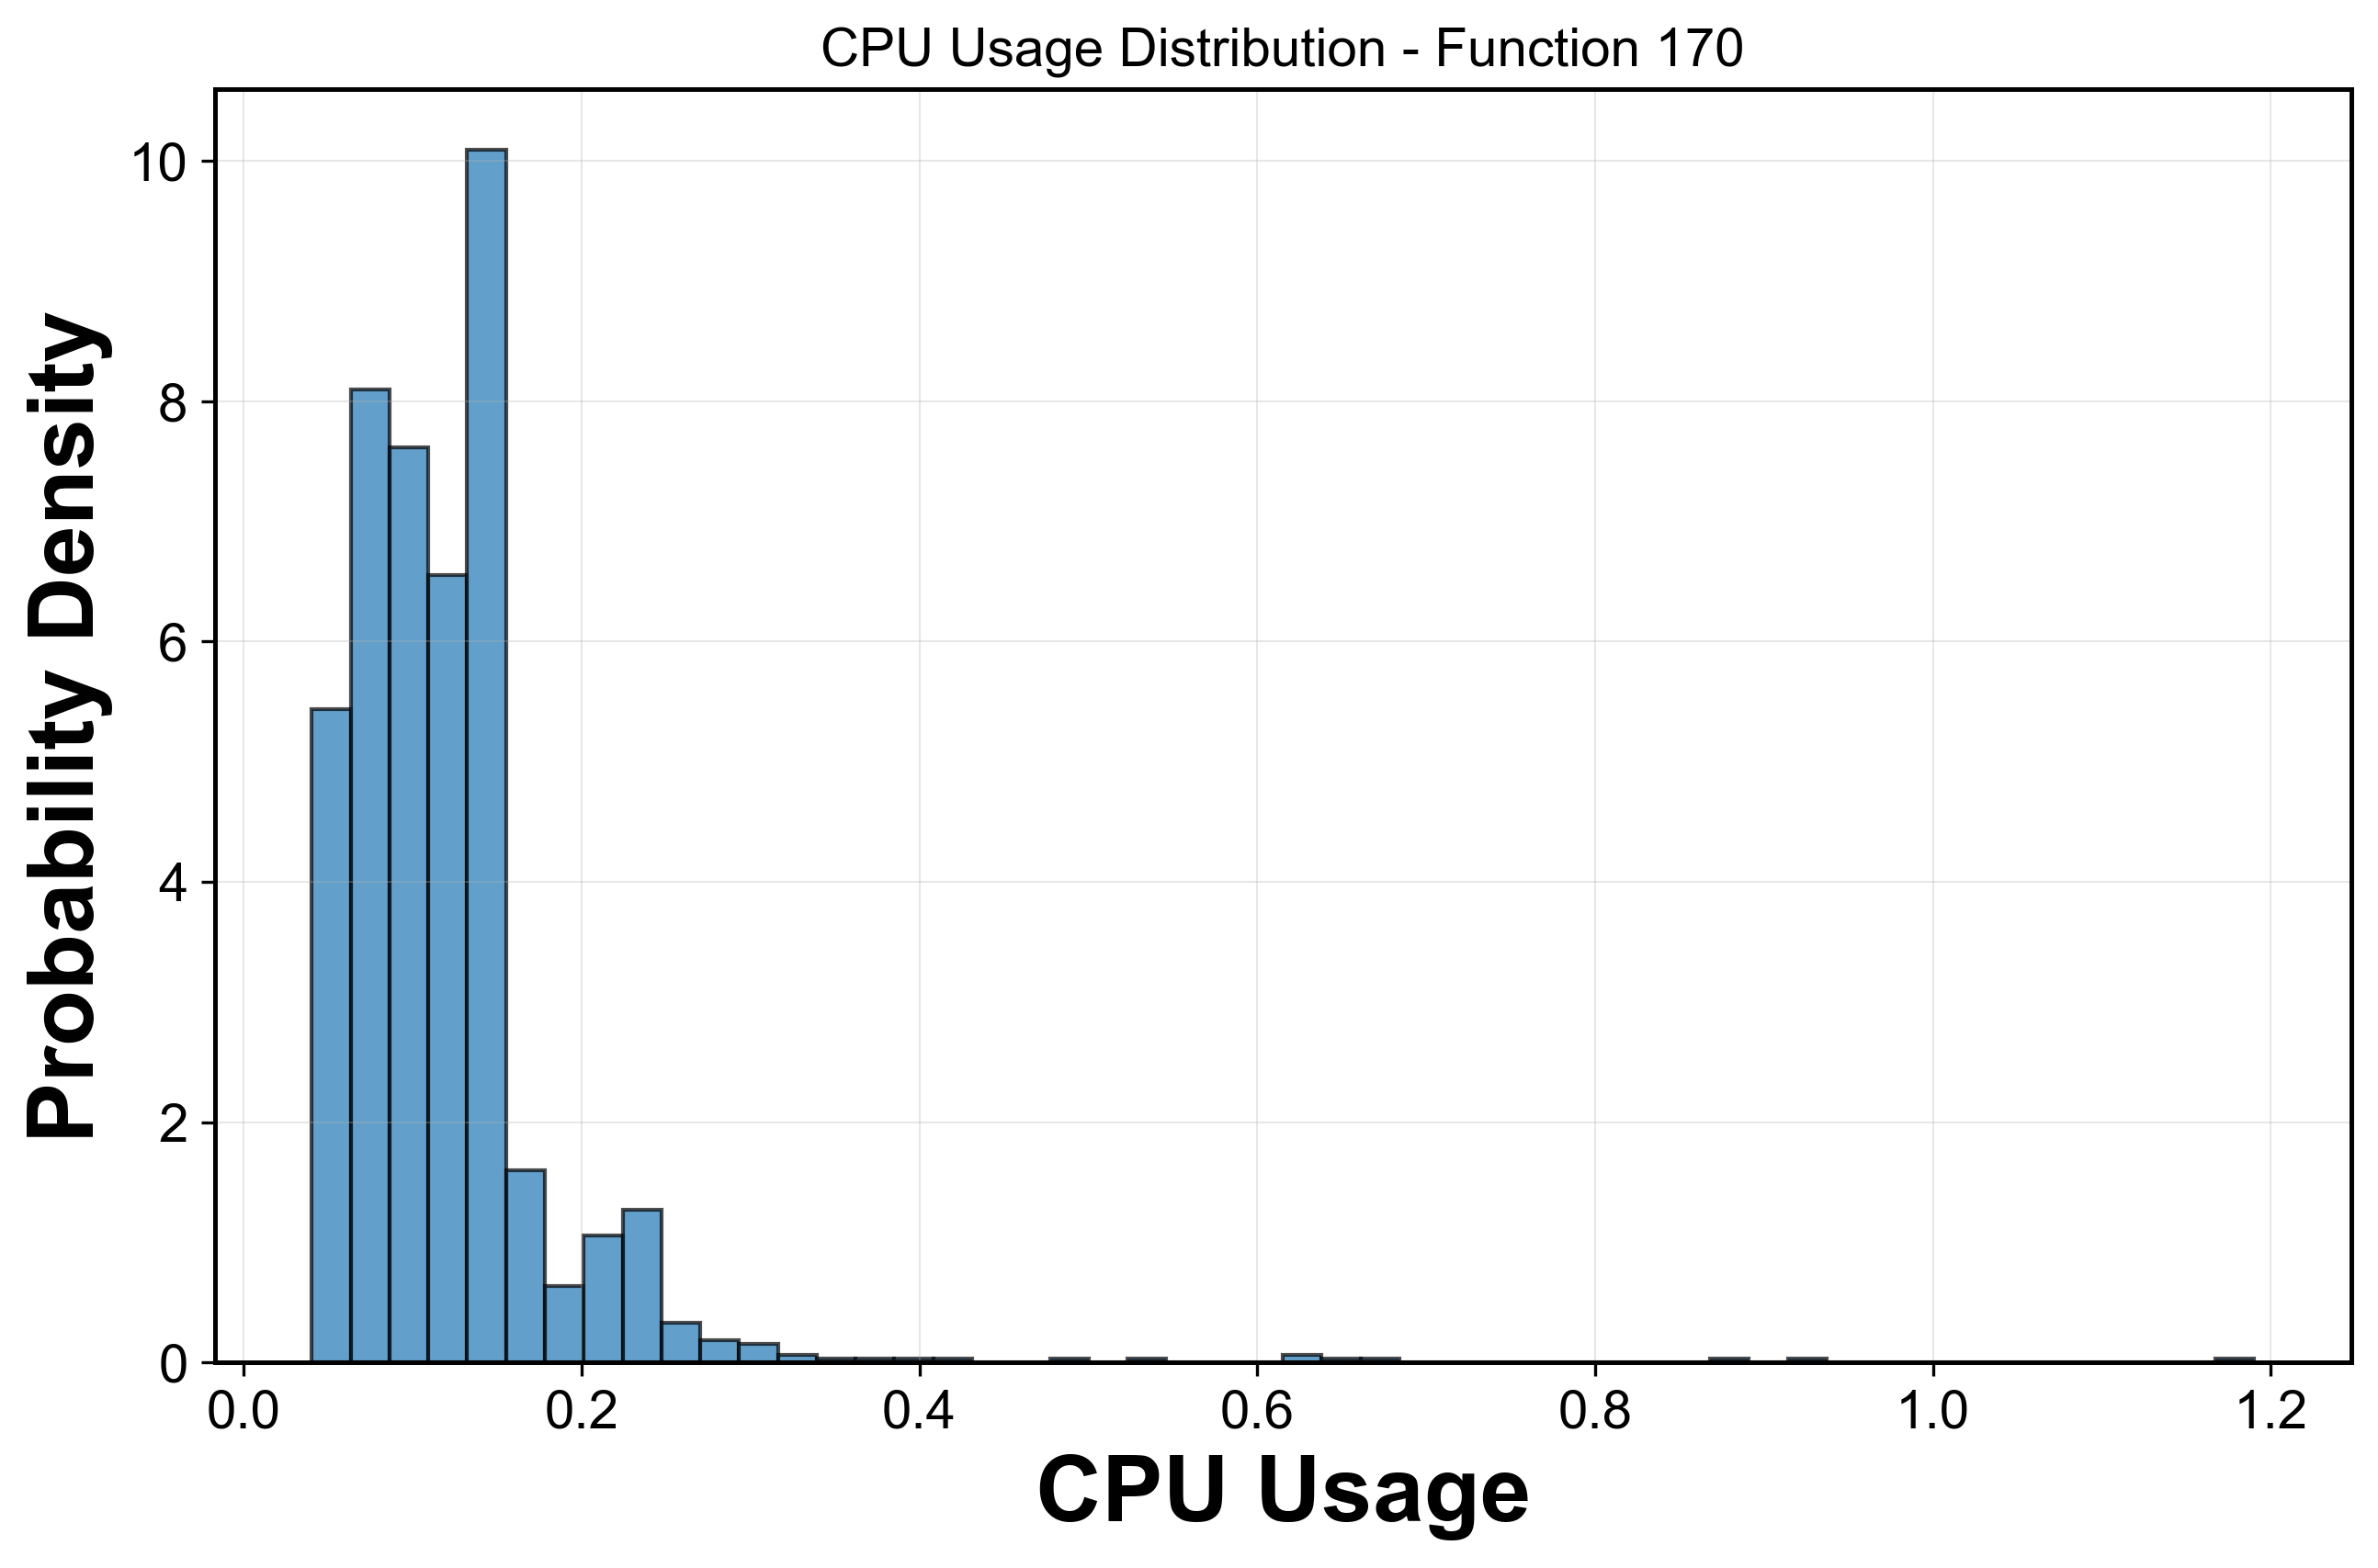

In [145]:
# 使用
plot_cpu_density_simple("206")
plot_cpu_density_simple("134")
plot_cpu_density_simple("127")
plot_cpu_density_simple("170")


In [48]:
def plot_4_funcs_density(func_ids, function_folder='function'):
    """
    绘制4个funcName的CPU使用率概率密度图 (2x2排列)
    
    参数:
        func_ids: 4个函数ID的列表 [id1, id2, id3, id4]
        function_folder: 存放函数CSV文件的文件夹路径
    """
    if len(func_ids) != 4:
        print("请提供恰好4个函数ID")
        return
    
    # 极简风格设置
    plt.rcParams.update({
        'font.size': 8,
        'axes.titlesize': 13,
        'axes.linewidth': 0.8,
        'xtick.major.size': 3,
        'ytick.major.size': 3,
        'grid.linewidth': 0.5,
        'grid.alpha': 0.2,
        'savefig.dpi': 300,
        'savefig.bbox': 'tight',
    })
    
    # 创建2x2子图
    fig, axes = plt.subplots(2, 2, figsize=(7, 3))
    axes = axes.flatten()  # 将2x2转换为1x4数组
    
    # 收集所有数据用于统一横坐标范围
    all_data = []
    subplot_labels = ['(a)', '(b)', '(c)', '(d)']
    
    for idx, (func_id, subplot_label) in enumerate(zip(func_ids, subplot_labels)):
        func_id_str = str(func_id)
        file_path = Path(function_folder) / f"{func_id_str}.csv"
        
        if not file_path.exists():
            print(f"警告: 找不到文件 {file_path}")
            axes[idx].text(0.5, 0.5, f'File Not Found\nID: {func_id}', 
                          ha='center', va='center', transform=axes[idx].transAxes)
            axes[idx].set_title(f'Func {func_id}')
            continue
        
        # 读取数据
        cpu_data = []
        try:
            for chunk in pd.read_csv(file_path, chunksize=100000):
                if 'cpu_usage' in chunk.columns:
                    cpu_series = pd.to_numeric(chunk['cpu_usage'], errors='coerce')
                    valid_data = cpu_series.dropna()
                    cpu_data.extend(valid_data.tolist())
        except Exception as e:
            print(f"读取文件 {func_id} 时出错: {e}")
            axes[idx].text(0.5, 0.5, f'Read Error\nID: {func_id}', 
                          ha='center', va='center', transform=axes[idx].transAxes)
            axes[idx].set_title(f'Func {func_id}')
            continue
        
        if not cpu_data:
            axes[idx].text(0.5, 0.5, f'No Data\nID: {func_id}', 
                          ha='center', va='center', transform=axes[idx].transAxes)
            axes[idx].set_title(f'Func {func_id}')
            continue
        
        cpu_array = np.array(cpu_data)
        all_data.extend(cpu_data)  # 收集所有数据
        
        # 计算直方图
        counts, bins = np.histogram(cpu_array, bins=100)
        
        # 转换为概率密度
        bin_width = bins[1] - bins[0]
        density = counts / (len(cpu_array) * bin_width)
        
        # 绘制直方图（只展示走势）
        axes[idx].hist(cpu_array, bins=50, density=True, 
                      alpha=0.7, edgecolor='none', linewidth=0, color="#000000")
        
        # 隐藏具体刻度值
        axes[idx].set_xticks([])
        axes[idx].set_yticks([])
        
        # 设置子图标题（显示函数ID）
        # axes[idx].set_title(f'Function {func_id}', fontsize=9, pad=-50)
        
        axes[idx].text(0.5, -0.03, subplot_label, 
                    transform=axes[idx].transAxes,
                    fontsize=12,
                    fontweight='bold',
                    fontfamily='Times New Roman',  # 只有子图编号用Times New Roman
                    ha='left', va='top')
        
    # 设置统一的横坐标和纵坐标标题
    fig.text(0.5, -0.05, 'CPU Usage', ha='center', fontsize=14, fontweight='bold')
    fig.text(0.02, 0.5, 'Probability Density', va='center', rotation='vertical', 
             fontsize=14, fontweight='bold')
    
    # 调整子图间距
    plt.subplots_adjust(wspace=0.05, hspace=0.2, 
                       left=0.05, right=0.95, 
                       bottom=0.08, top=0.95)
    
    # 保存图像
    output_file = f"cpu_density_4funcs_{'_'.join(map(str, func_ids))}.pdf"
    plt.savefig(output_file, dpi=300)
    print(f"图像已保存为: {output_file}")
    
    plt.show()

图像已保存为: cpu_density_4funcs_134_127_170_206.pdf


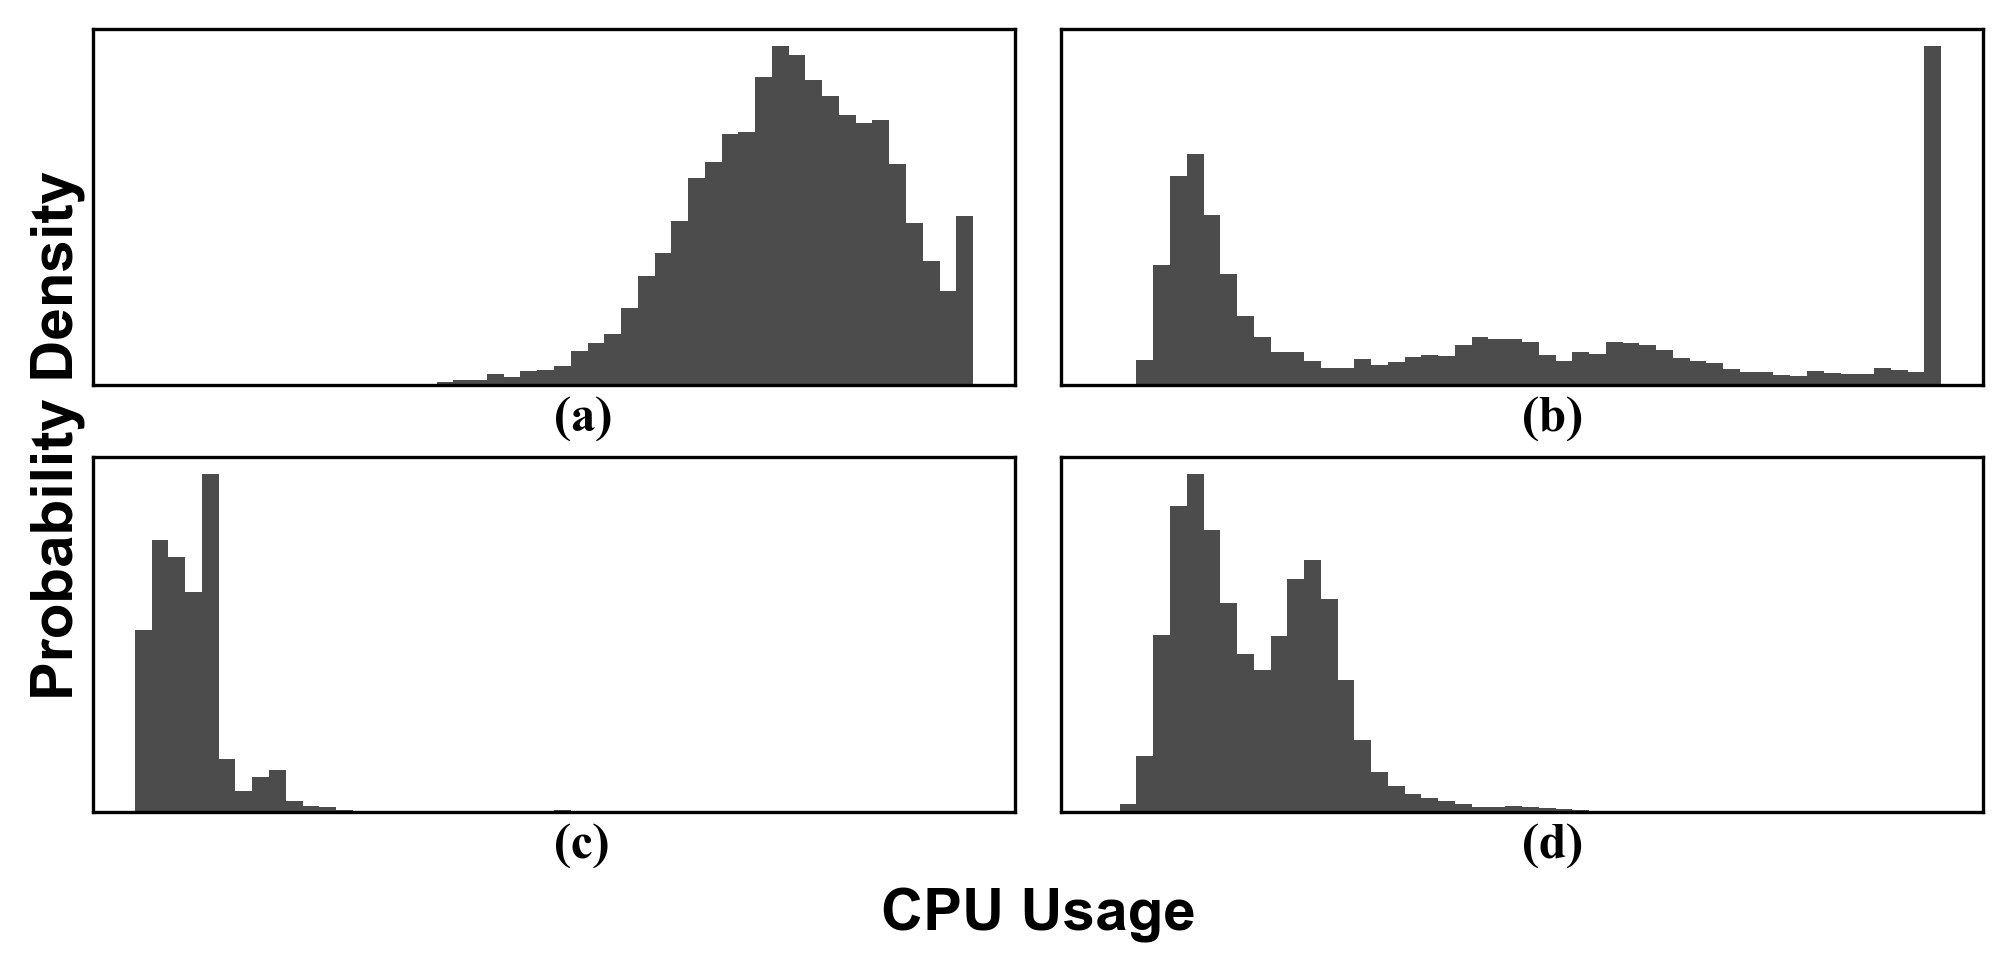

In [49]:
func_ids = [134, 127, 170, 206]  # 示例ID，请替换为您的实际ID
plot_4_funcs_density(func_ids)